In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import callbacks, layers

from scipy.special import gamma # for gamma func stuff
from mpl_toolkits.mplot3d import Axes3D # to make 3d plots

## generating the x^2 random coordinates 
class RandomCoordinates(object):
    def __init__(self, origin):
        self.origin_ = origin
        self.v0_ = normalize_weights(
            [np.random.normal(size=w.shape) for w in origin], origin
        )
        self.v1_ = normalize_weights(
            [np.random.normal(size=w.shape) for w in origin], origin
        )

    def __call__(self, a, b):
        return [
            a * w0 + b * w1 + wc
            for w0, w1, wc in zip(self.v0_, self.v1_, self.origin_)
        ]


def normalize_weights(weights, origin):
    return [
        w * np.linalg.norm(wc) / np.linalg.norm(w)
        for w, wc in zip(weights, origin)
    ]


class LossSurface(object):
    def __init__(self, model, inputs, outputs):
        self.model_ = model
        self.inputs_ = inputs
        self.outputs_ = outputs

    def compile(self, range, points, coords):
        a_grid = tf.linspace(-1.0, 1.0, num=points) ** 3 * range
        b_grid = tf.linspace(-1.0, 1.0, num=points) ** 3 * range
        loss_grid = np.empty([len(a_grid), len(b_grid)])
        for i, a in enumerate(a_grid):
            for j, b in enumerate(b_grid):
                self.model_.set_weights(coords(a, b))
                loss = self.model_.test_on_batch(
                    self.inputs_, self.outputs_, return_dict=True
                )["loss"]
                loss_grid[j, i] = loss
        self.model_.set_weights(coords.origin_)
        self.a_grid_ = a_grid
        self.b_grid_ = b_grid
        self.loss_grid_ = loss_grid

    def plot(self, range=1.0, points=24, levels=20, ax=None, **kwargs):
        xs = self.a_grid_
        ys = self.b_grid_
        zs = self.loss_grid_
        if ax is None:
            _, ax = plt.subplots(**kwargs)
            ax.set_aspect("equal")
        # Set Levels
        min_loss = zs.min()
        max_loss = zs.max()
        levels = tf.exp(
            tf.linspace(
                tf.math.log(min_loss), tf.math.log(max_loss), num=levels
            )
        )
        # Create Contour Plot
        CS = ax.contour(
            xs,
            ys,
            zs,
            levels=levels,
            cmap="magma",
            linewidths=0.75,
            alpha=0.75
        )
        ax.clabel(CS, inline=True, fontsize=12, fmt="%1.2f")
        return ax
    
def train_sample_model(af='relu'):
    # define the model
    # fit a fully-connected network (ie, a multi-layer perceptron)
    model = keras.Sequential([
      layers.Dense(64, activation=af),
      layers.Dense(64, activation=af),
      layers.Dense(64, activation=af),
      layers.Dense(1)
    ])
    model.compile(
      loss='mse',
      optimizer='adam',
    )
    history = model.fit(
      ds,
      epochs=50,
      verbose=0,
    )
    return model
   
def generate_loss_surface(x_range, y_range, af):
    # make empty grid
    a_grid = np.linspace(x_range, y_range, num=30)
    b_grid = np.linspace(x_range, y_range, num=30)
    loss_grid = np.empty((len(a_grid), len(b_grid)))

    # iterate through grid and populate
    for i, a in enumerate(a_grid):
        for j, b in enumerate(b_grid):
            model.set_weights(coords(a, b)) # based on random coords from other graph

            loss = model.evaluate(x, y, verbose=0)
            loss_grid[i, j] = loss

    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(111, projection='3d')
    A, B = np.meshgrid(a_grid, b_grid)
    ax.plot_surface(A, B, loss_grid, cmap='rainbow')

#     ax.set_zlabel('Loss')
    ax.set_title(af)
    af = ''.join(af.split()).lower()
    plt.tight_layout()
    plt.savefig('images/loss-surfaces/'+af+'-loss-surface.png', dpi=600)
    plt.show()

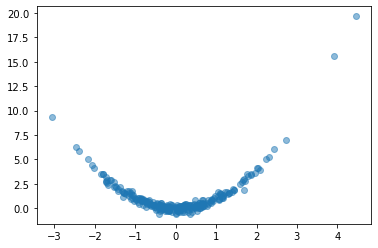

In [2]:
NUM_EXAMPLES = 256
BATCH_SIZE = 64

x = tf.random.normal(shape=(NUM_EXAMPLES, 1))
err = tf.random.normal(shape=x.shape, stddev=0.25)
y = x ** 2 + err
y = tf.squeeze(y)
ds = (tf.data.Dataset
      .from_tensor_slices((x, y))
      .shuffle(NUM_EXAMPLES)
      .batch(BATCH_SIZE))

plt.plot(x, y, 'o', alpha=0.5);
plt.show()

# ReLU

94/94 [==============================] - 0s 2ms/step


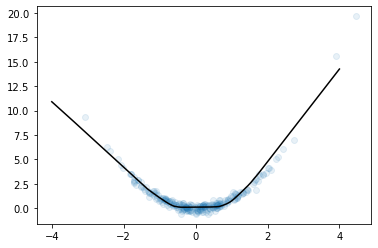

In [3]:
model = train_sample_model(af='relu')

# Look at fitted curve
grid = tf.linspace(-4, 4, 3000)
fig, ax = plt.subplots()
ax.plot(x, y, 'o', alpha=0.1)
ax.plot(grid, model.predict(grid).reshape(-1, 1), color='k')

<Figure size 3600x2400 with 0 Axes>

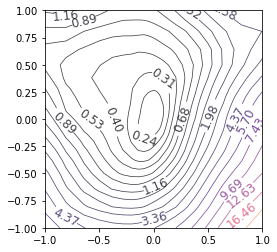

In [4]:
# Create loss surface
coords = RandomCoordinates(model.get_weights())
loss_surface = LossSurface(model, x, y)
loss_surface.compile(points=30, range=1, coords=coords)

# Look at loss surface
plt.figure(dpi=600)
loss_surface.plot()

# plt.tight_layout()
# plt.savefig('images/relu_loss_surface.png', dpi=600)

plt.show()

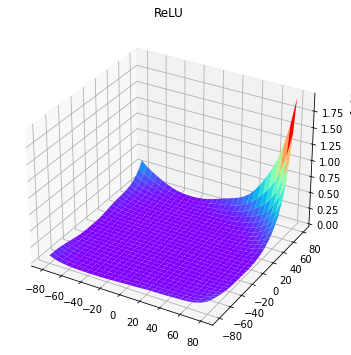

In [5]:
generate_loss_surface(-80, 80, 'ReLU')

## Tanh

94/94 [==============================] - 0s 3ms/step


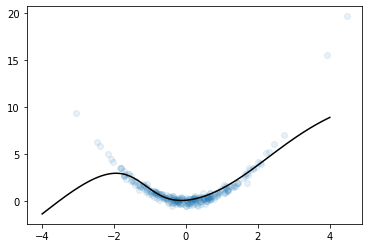

In [6]:
# Fit a fully-connected network (ie, a multi-layer perceptron)
model = train_sample_model(af='tanh')

# Look at fitted curve
grid = tf.linspace(-4, 4, 3000)
fig, ax = plt.subplots()
ax.plot(x, y, 'o', alpha=0.1)
ax.plot(grid, model.predict(grid).reshape(-1, 1), color='k')

<Figure size 3600x2400 with 0 Axes>

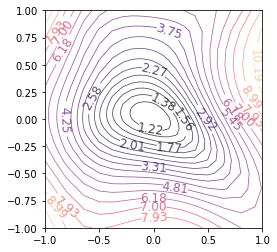

In [7]:
# Create loss surface
coords = RandomCoordinates(model.get_weights())
loss_surface = LossSurface(model, x, y)
loss_surface.compile(points=30, range=1, coords=coords)

# Look at loss surface
plt.figure(dpi=600)
loss_surface.plot()
plt.show()

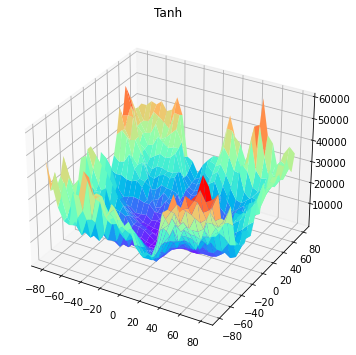

In [8]:
generate_loss_surface(-80, 80, 'Tanh')

## Swish

94/94 [==============================] - 0s 3ms/step


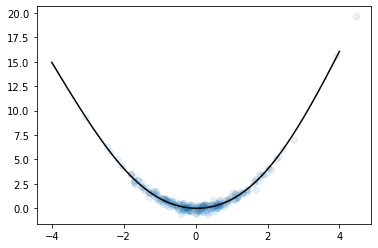

In [9]:
# Fit a fully-connected network (ie, a multi-layer perceptron)
model = train_sample_model(af='swish')

# Look at fitted curve
grid = tf.linspace(-4, 4, 3000)
fig, ax = plt.subplots()
ax.plot(x, y, 'o', alpha=0.1)
ax.plot(grid, model.predict(grid).reshape(-1, 1), color='k')

<Figure size 3600x2400 with 0 Axes>

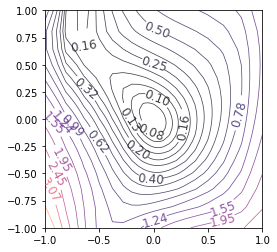

In [10]:
# Create loss surface
coords = RandomCoordinates(model.get_weights())
loss_surface = LossSurface(model, x, y)
loss_surface.compile(points=30, range=1, coords=coords)

# Look at loss surface
plt.figure(dpi=600)
loss_surface.plot()
plt.show()

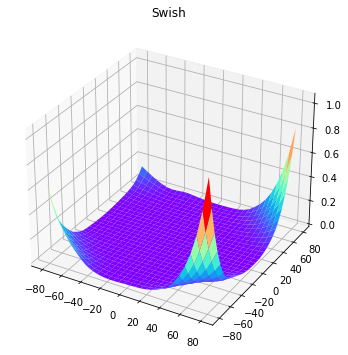

In [11]:
generate_loss_surface(-80, 80, 'Swish')

## GenGamma

In [15]:
'''
HYPERPARAMETERS
'''

a = 1 # alpha
c = 3 # gamma
mu = -2.6  # mu location parameter
b = 3 # beta
sf = 1.17 # scale factor

'''
FUNCTIONS
'''
def generalized_gamma(x):
    x = tf.math.divide(x-mu, b)
    func = tf.math.divide(tf.math.exp(-x**c)*c*x**((c*a)-1), gamma(a))    
    return tf.where(x>0, tf.math.divide(func, sf), 0)

def gamma_derivative(x): # i changed this to be compatiable that might b why it doesnt graph correctly
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(x)
        y = generalized_gamma(x)
    dy_dx = tape.gradient(y, x)
    return dy_dx

'''
Activation function definition 
'''
@tf.custom_gradient
def gamma_activation(x):
    def grad(dy):
        return gamma_derivative(x) * dy

    result = generalized_gamma(x)
    return result, grad

94/94 [==============================] - 1s 4ms/step


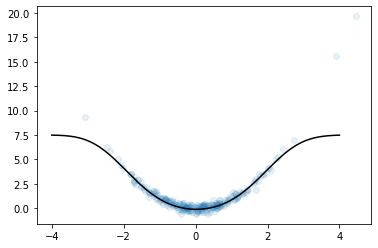

In [16]:
# Fit a fully-connected network (ie, a multi-layer perceptron)
model = train_sample_model(af=gamma_activation)

# Look at fitted curve
grid = tf.linspace(-4, 4, 3000)
fig, ax = plt.subplots()
ax.plot(x, y, 'o', alpha=0.1)
ax.plot(grid, model.predict(grid).reshape(-1, 1), color='k')

<Figure size 3600x2400 with 0 Axes>

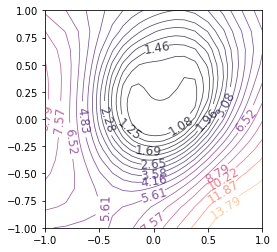

In [17]:
# Create loss surface
coords = RandomCoordinates(model.get_weights())
loss_surface = LossSurface(model, x, y)
loss_surface.compile(points=30, range=1, coords=coords)

# Look at loss surface
plt.figure(dpi=600)
loss_surface.plot()
plt.show()

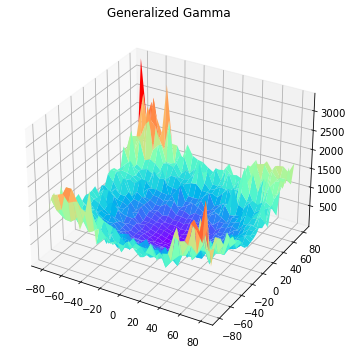

In [18]:
generate_loss_surface(-80, 80, 'Generalized Gamma')

## Tent

In [19]:
'''
FUNCTIONS
'''
tent_delta = 1

def tent(x):
    return tf.math.maximum(0.00, tent_delta-tf.math.abs(x))

def tent_derivative(x):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(x)
        y = tent(x)
    dy_dx = tape.gradient(y, x)
    return dy_dx

'''
Activation function definition 
'''
@tf.custom_gradient
def tent_activation(x):
    def grad(dy):
        return tent_derivative(x) * dy

    result = tent(x)
    return result, grad

94/94 [==============================] - 0s 3ms/step


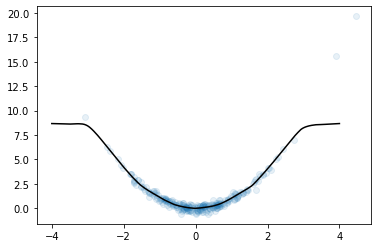

In [20]:
# Fit a fully-connected network (ie, a multi-layer perceptron)
model = train_sample_model(af=tent_activation)

# Look at fitted curve
grid = tf.linspace(-4, 4, 3000)
fig, ax = plt.subplots()
ax.plot(x, y, 'o', alpha=0.1)
ax.plot(grid, model.predict(grid).reshape(-1, 1), color='k')

<Figure size 3600x2400 with 0 Axes>

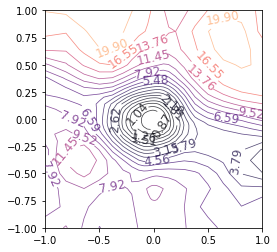

In [21]:
# Create loss surface
coords = RandomCoordinates(model.get_weights())
loss_surface = LossSurface(model, x, y)
loss_surface.compile(points=30, range=1, coords=coords)

# Look at loss surface
plt.figure(dpi=600)
loss_surface.plot()
plt.show()

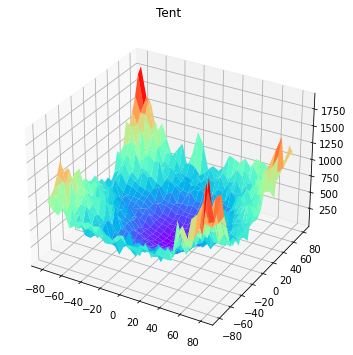

In [22]:
generate_loss_surface(-80, 80, 'Tent')